# Script to visualize predictions of a Model
Utilized to create single figures for the Beleg

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import keras.backend as K
import os

Using TensorFlow backend.
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julien/anaconda3/

## Custom Loss Function needed to allow loading of Model

In [11]:
def Masked_Mean_Absolute_Error(y_true, y_pred):
    '''Masked mean absolut error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    loss = K.mean(
                K.sum(
                        K.abs(y_true - y_pred) * A_i,
                        axis=(1,2,3)
                     )
                /
                K.sum(A_i, axis=(1,2,3))
            )
    lower_boundary = K.less(y_pred, 0)
    lower_boundary = K.cast(lower_boundary, dtype='float32')
    upper_boundary = K.greater(y_pred, 65535)
    upper_boundary = K.cast(upper_boundary, dtype='float32')
    interval_loss = K.sum(lower_boundary * 10000 + upper_boundary * 10000)   
    return loss+interval_loss


def Masked_Root_Mean_Squared_Error(y_true, y_pred):
    '''Masked root mean squared error custom loss function'''
    # create binary artifact maps from ground truth depth maps
    A_i = K.greater(y_true, 0)
    A_i = K.cast(A_i, dtype='float32')
    # original K.sqrt(K.mean(K.square(y_true - y_pred)))
    loss = K.sqrt(
            K.mean(
                    K.sum(
                            K.square(y_true - y_pred) * A_i,
                            axis=(1,2,3)
                         )
                    /
                    K.sum(A_i, axis=(1,2,3))
                  )
            )
    lower_boundary = K.less(y_pred, 0)
    lower_boundary = K.cast(lower_boundary, dtype='float32')
    upper_boundary = K.greater(y_pred, 65535)
    upper_boundary = K.cast(upper_boundary, dtype='float32')
    interval_loss = K.sum(lower_boundary * 10000 + upper_boundary * 10000)   
    return loss+interval_loss

def berHu(c):
    '''Reverse Huber loss as stated in paper "Deeper Depth Prediction with Fully Convolutional Residual Networks" by Laina et al. and "The berhu
       penalty and the grouped effect" by L. Zwald and S. Lambert-Lacroix'''
    # does this current implementation makes sense? --> yes, it returns mae or mse
    # TODO implement this with binary mask too?
    def inverse_huber(y_true, y_pred):
        threshold = c * K.max(K.abs(y_true - y_pred))
        absolute_mean = K.mean(K.abs(y_true - y_pred))
        mask = K.less_equal(absolute_mean, threshold)
        mask = K.cast(mask, dtype='float32')
        return mask * absolute_mean + (1-mask) * K.mean(K.square(K.abs(y_true - y_pred)))
    return inverse_huber

## Different Path Variables

In [16]:
path_models = '/media/julien/Transcend/Beleg/results/models'
path_images = 'Images'

## Load the Models to Visualize

In [18]:
model_mmae = load_model(os.path.join(path_models, 'model_sgd_100_MMAE.h5'), custom_objects={'Masked_Mean_Absolute_Error':Masked_Mean_Absolute_Error, 'Masked_Root_Mean_Squared_Error':Masked_Root_Mean_Squared_Error, 'inverse_huber':berHu(0.2)})
#model_mmae = load_model(os.path.join(path_models, 'model_bmae.h5'), custom_objects={'Binary_Mean_Absolut_Error': Masked_Mean_Absolute_Error})

## Load the images

In [19]:
color = cv2.imread(os.path.join(path_images, '44_color.jpg'), cv2.IMREAD_COLOR)
depth = cv2.imread(os.path.join(path_images, '44_depth.png'), cv2.IMREAD_ANYDEPTH)
ir = cv2.imread(os.path.join(path_images, '44_infrared.png'), cv2.IMREAD_ANYDEPTH)

img_c = (color/255.).astype(np.float32).reshape(1,480,640,3)
img_ir = (ir/65535.).astype(np.float32).reshape(1,480,640,1)

print('Color: ' + str(color.shape) + ' ' + str(color.dtype))
print('Rescaled Color: ' + str(img_c.shape) + ' ' + str(img_c.dtype))
print('Infrared: ' + str(ir.shape) + ' ' + str(ir.dtype))
print('Rescaled Infrared: ' + str(img_ir.shape) + ' ' + str(img_ir.dtype))
print('Depth: ' + str(depth.shape) + ' ' + str(depth.dtype))

Color: (480, 640, 3) uint8
Rescaled Color: (1, 480, 640, 3) float32
Infrared: (480, 640) uint16
Rescaled Infrared: (1, 480, 640, 1) float32
Depth: (480, 640) uint16


## Predict the Depth with each of the Models

In [35]:
#pred_mae = model_mae.predict([img_c, img_ir])
pred_mmae = model_mmae.predict([img_c, img_ir])

#print('Prediction MAE: ' + str(pred_mae.shape) + ' ' + str(pred_mae.dtype))
print('Prediction MMAE: ' + str(pred_mmae.shape) + ' ' + str(pred_mmae.dtype))

Prediction MMAE: (1, 480, 640, 1) float32


## Print Min and Max Values from Predictions and Ground Truth

In [36]:
#print('Prediction MAE Max / Min: ' + str(np.amax(pred_mae)) + ' / ' + str(np.amin(pred_mae)))
print('Prediction MMAE Max / Min: ' + str(np.amax(pred_mmae)) + ' / ' + str(np.amin(pred_mmae)))
print('Ground Truth Max / Min: ' + str(np.amax(depth)) + ' / ' + str(np.amin(depth)))

Prediction MMAE Max / Min: 165861.53 / -52302.49
Ground Truth Max / Min: 13118 / 0


## Transform to uint16 and Print Values again

In [37]:
#mae = np.clip(pred_mae, 0, 65535)
#mae = mae.astype(np.uint16).reshape(480,640)
mmae = np.clip(pred_mmae, 0, 65535)
mmae = pred_mmae.astype(np.uint16).reshape(480,640)
#mmae[mmae>14000]=0

#print('Prediction MAE Max / Min: ' + str(np.amax(mae)) + ' / ' + str(np.amin(mae)))
print('Prediction MMAE Max / Min: ' + str(np.amax(mmae)) + ' / ' + str(np.amin(mmae)))
print('Ground Truth Max / Min: ' + str(np.amax(depth)) + ' / ' + str(np.amin(depth)))

Prediction MMAE Max / Min: 65530 / 2
Ground Truth Max / Min: 13118 / 0


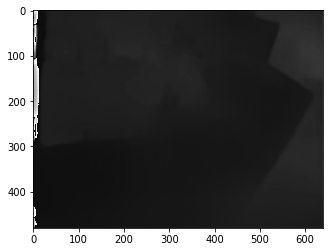

In [38]:
%matplotlib inline
plt.imshow(mmae, cmap="gray")
plt.show()

Ground Truth


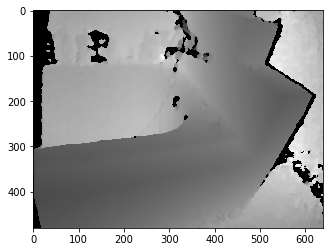

MMAE


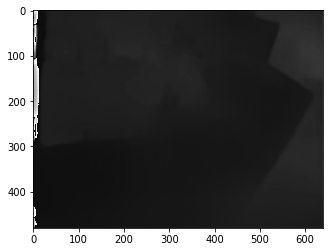

MMAE edited


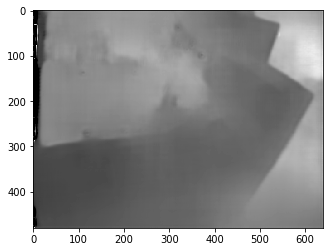

In [39]:
%matplotlib inline
print('Ground Truth')
plt.imshow(depth, cmap="gray")
plt.show()
#print('MAE')
#plt.imshow(mae, cmap="gray")
#plt.show()
print('MMAE')
plt.imshow(mmae, cmap="gray")
plt.show()
mmae_edited = mmae.copy()
mmae_edited[mmae_edited>15000] = 0
print('MMAE edited')
plt.imshow(mmae_edited, cmap="gray")
plt.show()

## Save Results

In [69]:
cv2.imwrite(os.path.join(path_images, 'val_2_pred_mae.png'), mae)
cv2.imwrite(os.path.join(path_images, 'val_2_pred_mmae.png'), mmae)
cv2.imwrite(os.path.join(path_images, 'val_2_pred_mmae_edited.png'), mmae_edited)

True

## Normalize Predictions and Ground Truth for later Colorization

In [40]:
#norm_depth = np.zeros(shape=depth.shape, dtype=np.uint16)
#norm_mae = np.zeros(shape=mae.shape, dtype=np.uint16)
#norm_mmae = np.zeros(shape=mmae.shape, dtype=np.uint16)
#norm_mmae_edited = np.zeros(shape=mmae_edited.shape, dtype=np.uint16)

norm_depth = cv2.normalize(depth, None, 0, 65535, cv2.NORM_MINMAX)
#norm_mae = cv2.normalize(mae, None, 0, 65535, cv2.NORM_MINMAX)
norm_mmae = cv2.normalize(mmae, None, 0, 65535, cv2.NORM_MINMAX)
norm_mmae_edited = cv2.normalize(mmae_edited, None, 0, 65535, cv2.NORM_MINMAX)

### Visualize Normalization

Ground Truth


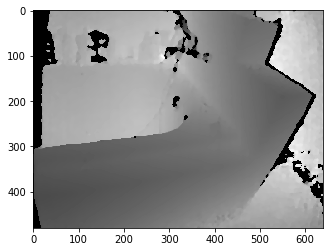

MMAE


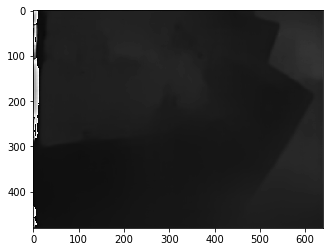

MMAE edited


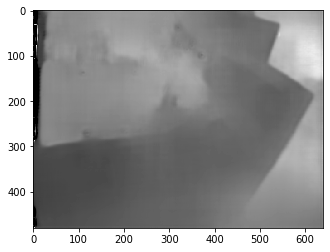

In [41]:
%matplotlib inline
print('Ground Truth')
plt.imshow(norm_depth, cmap="gray")
plt.show()
#print('MAE')
#plt.imshow(norm_mae, cmap="gray")
#plt.show()
print('MMAE')
plt.imshow(norm_mmae, cmap="gray")
plt.show()
print('MMAE edited')
plt.imshow(norm_mmae_edited, cmap="gray")
plt.show()

In [42]:
cv2.imwrite(os.path.join(path_images, 'predicted_normalized.png'), norm_mmae_edited)

True

## Stack images into one image

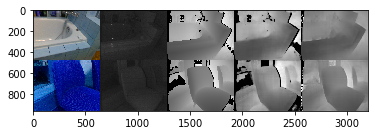

True

In [41]:
%matplotlib inline

# load already computed images
g_color = cv2.imread(os.path.join(path_images, 'buffer', '5143_color.jpg'), cv2.IMREAD_COLOR)
g_ir = cv2.imread(os.path.join(path_images, 'buffer', '5143_infrared.png'), cv2.IMREAD_ANYDEPTH)
g_ir = cv2.cvtColor((g_ir/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
n_depth = cv2.imread(os.path.join(path_images, 'buffer', 'train_norm_pred_depth.png'), cv2.IMREAD_ANYDEPTH)
n_depth = cv2.cvtColor((n_depth/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
n_mae = cv2.imread(os.path.join(path_images, 'buffer', 'train_norm_pred_mae.png'), cv2.IMREAD_ANYDEPTH)
n_mae = cv2.cvtColor((n_mae/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
n_mmae_edited = cv2.imread(os.path.join(path_images, 'buffer', 'train_norm_pred_mmae_edited.png'), cv2.IMREAD_ANYDEPTH)
n_mmae_edited = cv2.cvtColor((n_mmae_edited/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)

ir_col = cv2.cvtColor((ir/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
depth_col = cv2.cvtColor((norm_depth/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
mae_col = cv2.cvtColor((norm_mae/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
mmae_edited_col = cv2.cvtColor((norm_mmae_edited/256).astype(np.uint8), cv2.COLOR_GRAY2RGB)
overview = np.concatenate((color, ir_col, depth_col, mae_col, mmae_edited_col), axis=1) # , norm_depth, norm_mae, norm_mmae_edited
overview2 = np.concatenate((g_color, g_ir, n_depth, n_mae, n_mmae_edited), axis=1)
result = np.concatenate((overview, overview2), axis=0)
plt.imshow(result)
plt.show()
cv2.imwrite(os.path.join(path_images, 'combination_result.png'), result)

## Save normalized images

In [91]:
cv2.imwrite(os.path.join(path_images, 'train_norm_pred_mae.png'), norm_mae)
cv2.imwrite(os.path.join(path_images, 'train_norm_pred_mmae.png'), norm_mmae)
cv2.imwrite(os.path.join(path_images, 'train_norm_pred_mmae_edited.png'), norm_mmae_edited)
cv2.imwrite(os.path.join(path_images, 'train_norm_pred_depth.png'), norm_depth)

True

## Colorize Depth Predictions and Ground Truth

In [77]:
color_depth = cv2.applyColorMap((norm_depth/256).astype(np.uint8), 2)
color_mae = cv2.applyColorMap((norm_mae/256).astype(np.uint8), 2)
color_mmae = cv2.applyColorMap((norm_mmae/256).astype(np.uint8), 2)
color_mmae_edited = cv2.applyColorMap((norm_mmae_edited/256).astype(np.uint8), 2)

Ground Truth


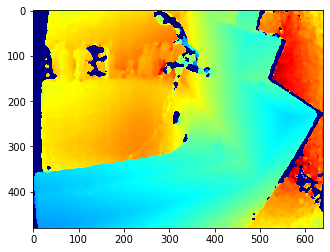

MAE


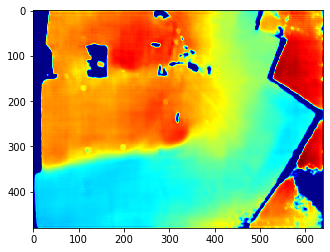

MMAE Edited


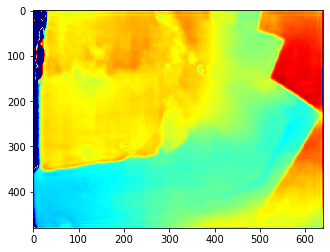

MMAE


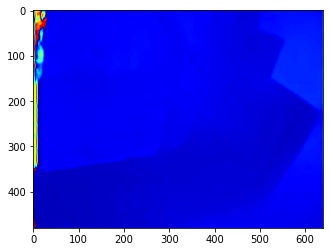

In [79]:
%matplotlib inline
print('Ground Truth')
plt.imshow(cv2.cvtColor(color_depth, cv2.COLOR_BGR2RGB))
plt.show()
print('MAE')
plt.imshow(cv2.cvtColor(color_mae, cv2.COLOR_BGR2RGB))
plt.show()
print('MMAE Edited')
plt.imshow(cv2.cvtColor(color_mmae_edited, cv2.COLOR_BGR2RGB))
plt.show()
print('MMAE')
plt.imshow(cv2.cvtColor(color_mmae, cv2.COLOR_BGR2RGB))
plt.show()